# Image Denoising with Stan

# What is Stan?

- Probabilistic Programming Language based on Markov Chain Monte Carlo (MCMC) for approximate inference
- Parameter estimations by sampling from Posterior 
- high-dimensional distributions or complex hierarchichal Bayesian models
- More efficient than random-walk (Gibbs, Metropolis-Hastings)
- Hamiltonian-Monte-Carlo: https://chi-feng.github.io/mcmc-demo/app.html#RandomWalkMH,banana
- Compiled into C++

In [25]:
# Libraries ---------------------------------------------------------------
library(jpeg)
library(imager)
library(purrr)
library(ggplot2)
library(rstan)
library(dplyr)
library(tidyr)
library(repr)
options(repr.plot.width=6, repr.plot.height=4)

# Linear Regression with Stan

### Create Random Data

Data are generated as

$$
y \sim \mathcal{N} (\alpha + \beta x, \sigma)
$$

with true values 

$$
\alpha = 4.0 \\
\beta = 0.5 \\
\sigma = 1.0 
$$

So let us create some data points in the interval $x \in [0, 10]$.

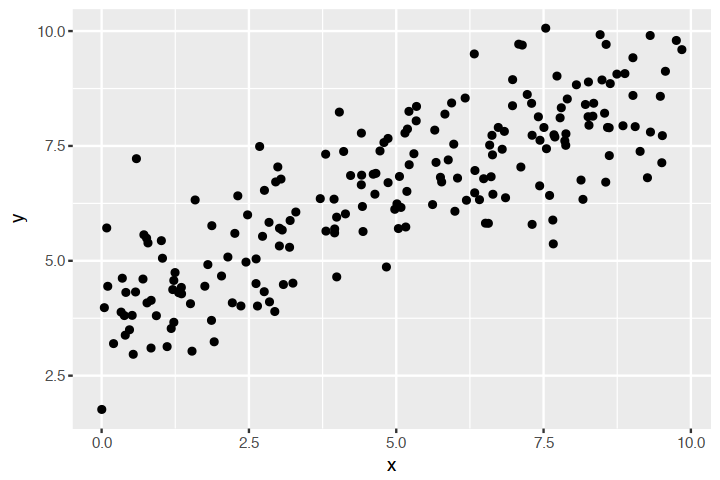

In [2]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0
N = 200

# Generate and plot data
x = 10 * runif(n = N)
y = alpha + beta * x
y = rnorm(N, mean = y, sd = sigma)
data <- tibble(x=x,y=y)

ggplot(data = data, aes(x = x, y = y)) + 
    geom_point()

### Defining the Stan model

A Stan model requires at least 3 blocks:
- Data block
- Parameters block
- Model block

In [3]:
lr_model <- "

//####################################################################################################
// ---------------------------------------- DATA BLOCK --------------------------------------------- #
//####################################################################################################

data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

//####################################################################################################
// -------------------------------------- PARAMETERS BLOCK ----------------------------------------- #
//####################################################################################################

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

//####################################################################################################
// ---------------------------------------- MODEL BLOCK -------------------------------------------- #
//####################################################################################################

model {
    y ~ normal(alpha + beta * x, sigma);
}
"

### Compile model

In [4]:
lr_stan <- stan_model(model_code=lr_model)

### Feed Data and sample
Sampling parameters:
- iter: Number of total sampling iterations
- chains: Number of chains with different starting points. 
- warmup: 'burn-in' number of samples to be discarded
- thin: discard every n-th sample due to correlations

In [5]:
# Define data
data_list<-list(
    x = x,
    y = y,
    N = length(x)
)

In [6]:
# Sample
lr_stan_fit <- sampling(
    object=lr_stan , 
    data = data_list , 
    chains = 3,
    iter = 1000, 
    warmup = 200, 
    thin = 1
)


SAMPLING FOR MODEL 'ebb47009d1ad313ddb9c62c2d06f047d' NOW (CHAIN 1).

Gradient evaluation took 0.000258 seconds
1000 transitions using 10 leapfrog steps per transition would take 2.58 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 201 / 1000 [ 20%]  (Sampling)
Iteration: 300 / 1000 [ 30%]  (Sampling)
Iteration: 400 / 1000 [ 40%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 0.648738 seconds (Warm-up)
               1.66275 seconds (Sampling)
               2.31149 seconds (Total)


SAMPLING FOR MODEL 'ebb47009d1ad313ddb9c62c2d06f047d' NOW (CHAIN 2).

Gradient evaluation took 0.000216 seconds
1000 transitions using 10 leapfrog steps 

### Plot information about the parameter $\beta$

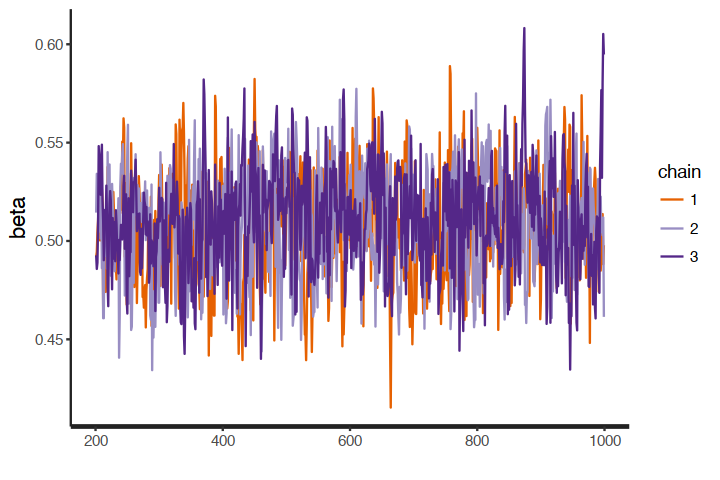

In [7]:
stan_trace(lr_stan_fit, pars=c("beta"))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


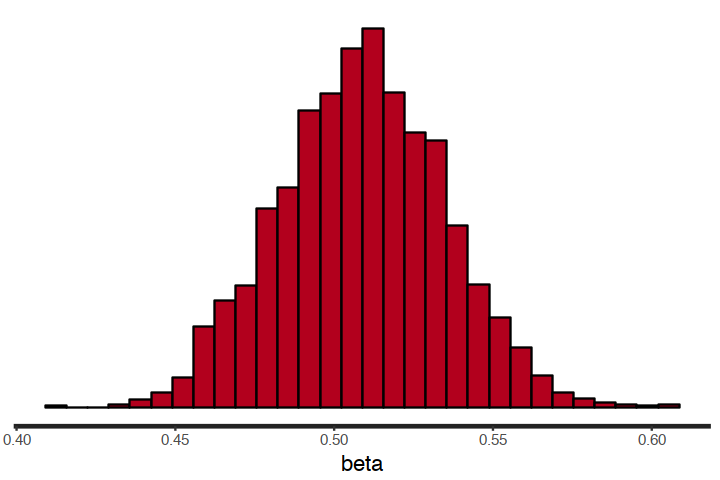

In [8]:
stan_hist(lr_stan_fit, pars=c("beta"))

### Summary of parameters

In [9]:
S <- summary(lr_stan_fit)
round(S$summary,3)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,4.001,0.005,0.145,3.710,3.905,4.003,4.102,4.270,766.559,1.004
beta,0.509,0.001,0.026,0.458,0.491,0.509,0.527,0.559,826.097,1.002
sigma,1.004,0.001,0.052,0.911,0.968,1.000,1.037,1.114,1496.324,1.003
lp__,-100.268,0.041,1.240,-103.501,-100.840,-99.952,-99.367,-98.828,897.143,1.008


In [10]:
df_lr_stan <- as.data.frame(lr_stan_fit)
lr_stan_alpha <- mean(df_lr_stan$alpha)
lr_stan_beta <- mean(df_lr_stan$beta)
lr_stan_sigma <- mean(df_lr_stan$sigma)

y_stan <- function(x) lr_stan_alpha + x*lr_stan_beta

data_stan <- tibble(x = x) %>% 
    mutate(y = y_stan(x))

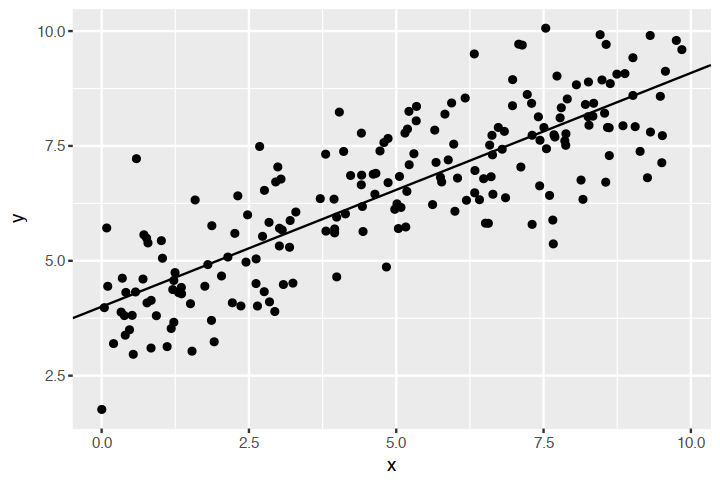

In [11]:
ggplot(data = data, aes(x = x, y = y)) + 
    geom_point() +
    geom_abline(intercept = lr_stan_alpha, slope = lr_stan_beta)

# Image Denoising

In [12]:
options(repr.plot.width=5, repr.plot.height=5)

In [13]:
# Load data
img_noise <- grayscale(load.image("greyscale.png"))
img_noisefree <- img_noise

In [14]:
rnorm_noise <- function(x, sigma){
    output <- rnorm(n = 1, mean = x, sd = sigma)
    if(output > 1){
        output <- 1
    } else if (output < 0) {
        output <- 0
    } 
    return(output)
}

img_noise[] <- apply(img_noise, 1:2, rnorm_noise, 0.1)

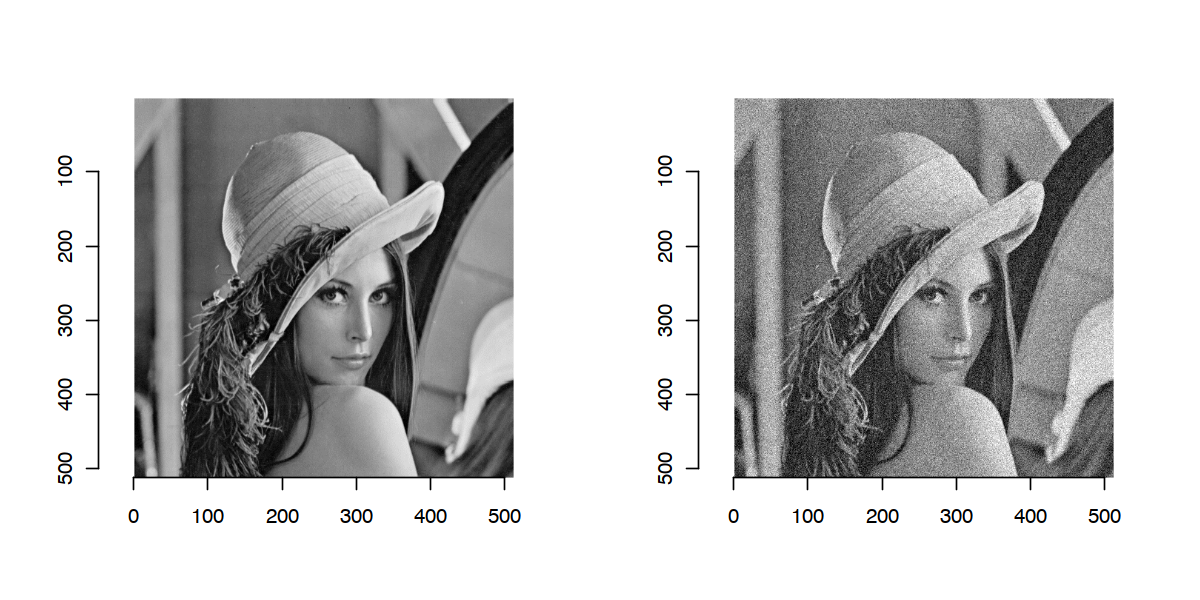

In [15]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(img_noisefree)
plot(img_noise)

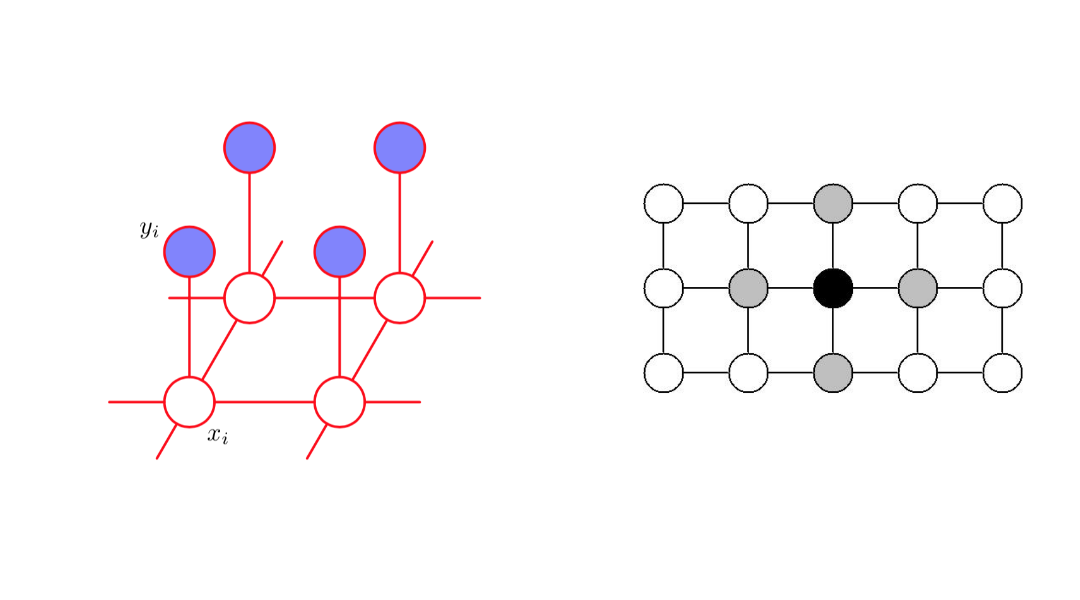

In [16]:
markov2d <- load.image("MarkovNetwork2d.png")
markov <- load.image("MarkovNetwork.png")

options(repr.plot.width=9, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(markov, axes = FALSE)
plot(markov2d, axes=FALSE)

### Energy function

- Markov Network as energy function

$$
E(x, y) = \sum_i V_i(x_i, y_i) + \sum_{\{i, j\}} V_{ij}(x_i, x_j).
$$

- Likelihood (assume Gaussian noise with magnitude $\sigma$):

$$
V_i(x_i, y_i) = \frac{(x_i - y_i)^2}{2\sigma^2}
$$

- Prior between neighboring pixels (penalization factor  $\gamma$, but only up to $\beta$):

$$
V_{ij}(x_i, x_j) = \gamma min((x_i - x_j)^2, \beta).
$$

- Image denoising: minimize $E(x, y)$


### Joint probability distribution
- Joint probability distribution: maximize probability

$$
p(x, y) = \frac{1}{Z} exp(-E(x, y)).
$$

- maximum-(log)-likelhood problem: Point-estimate (optimization)

$$
log~p(X|Y) \propto - \sum_i \frac{(x_i - y_i)^2}{2\sigma^2} - \sum_{\{i, j\}} \gamma min((x_i - x_j)^2, \beta)
$$

### Stan model

In [19]:
stan_string <- "

//####################################################################################################
// ---------------------------------------- FUNCTIONS BLOCK ---------------------------------------- #
//####################################################################################################

functions {
    real log_likelihood(matrix X, real sigma, matrix Y, int k, int l){
        real likelihood = pow(X[k,l] - Y[k,l], 2)/(2*pow(sigma, 2));
        return likelihood;
    }

    real log_prior(matrix X, real b, real g, matrix Y, int k, int l){

        real low = g*(fmin(pow(X[k,l] - X[k, l+1], 2), b));
        real up = g*(fmin(pow(X[k,l] - X[k, l-1], 2), b)); 
        real left  = g*(fmin(pow(X[k,l] - X[k-1, l], 2), b)); 
        real right = g*(fmin(pow(X[k,l] - X[k+1, l], 2), b));
        
        return low + up + left + right;
    }

    real log_posterior(matrix X, real s, real b, real g, matrix Y, int k, int l) {
        return -(log_likelihood(X, s, Y, k, l) + log_prior(X, b, g, Y, k, l));
    }

    real posterior_log(matrix X, real s, real b, real g, matrix Y, int m, int n){
        matrix[m,n] prob;
        real lprob;

        for (k in 1:m) {
            for (l in 1:n){
                if (l == 1 || l == n || k == 1 || k == m){
                    prob[k,l] = 0;
                } else {
                    prob[k,l] = log_posterior(X, s, b, g, Y, k, l);
                }
            }
        }

        lprob = sum(prob);
        return lprob;
    }

}

//####################################################################################################
// ---------------------------------------- DATA BLOCK --------------------------------------------- #
//####################################################################################################

data {
    int m;
    int n;
    real g;
    real b;
    real s;
    matrix<lower=0,upper=1>[m, n] Y;
}

//####################################################################################################
// -------------------------------------- PARAMETERS BLOCK ----------------------------------------- #
//####################################################################################################

parameters {
    matrix<lower=0,upper=1>[m, n] X;
}

//####################################################################################################
// ---------------------------------------- MODEL BLOCK -------------------------------------------- #
//####################################################################################################

model {
    X ~ posterior(s, b, g, Y, m, n);
}
"

stan_model_joint <- stan_model(model_code = stan_string)

### Optimization in Stan

In [21]:
Y <- matrix(img_noise, dim(img_noise)[1], dim(img_noise)[2])

rows = nrow(Y)
cols = ncol(Y)

image_data <- list(
    s = 0.15,
    b = 0.1,
    g = 50,
    m = rows,
    n = cols,
    Y = Y[1:rows, 1:cols]
) 

opti <- optimizing(stan_model_joint, 
                   data = image_data, 
                   verbose = TRUE)$par

Initial log joint probability = -3.5584e+06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -98649.3       7.74377       768.935        0.71        0.71       21   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -74362.2       1.45479       118.741       0.694       0.694       41   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -73332.8       0.50791       29.1711           1           1       61   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79      -73245.2     0.0804115      0.838986           1           1       83   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97      -73245.2    0.00652134     0.0609717           1           1      102   
Optimization terminated normally: 
  Convergence detected: re

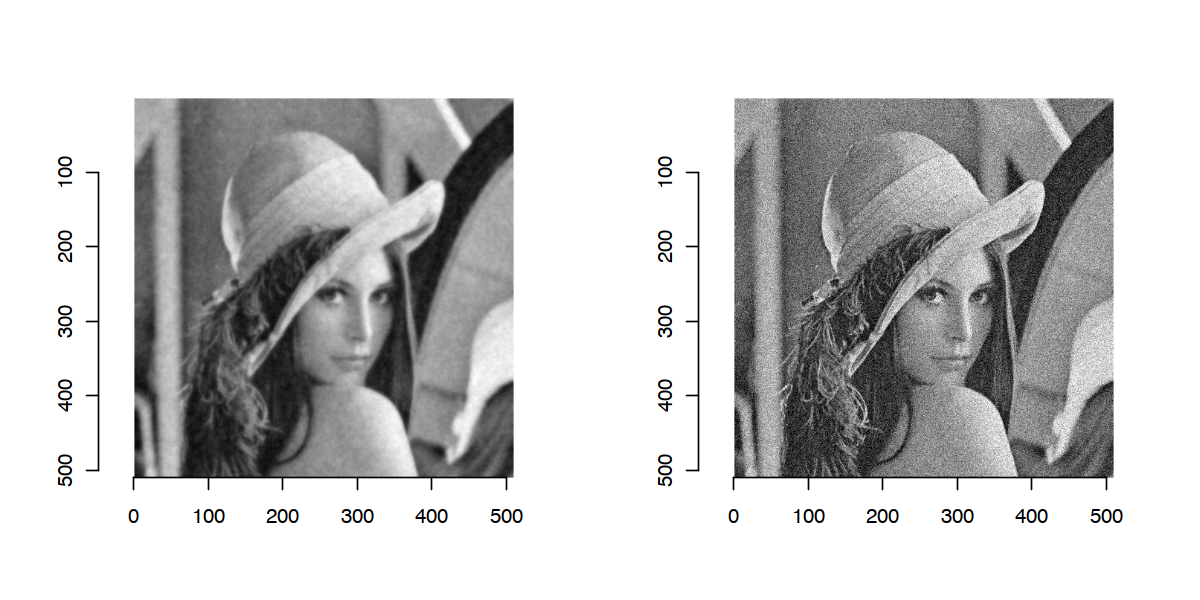

In [22]:
optimatrix = matrix(opti, nrow = rows, ncol = cols)

options(repr.plot.width=10, repr.plot.height=5)
par(mfrow = c(1, 2))
plot(as.cimg(optimatrix[2:(rows-1),2:(cols-1)]))
plot(as.cimg(Y[2:(rows-1),2:(cols-1)]))